In [1]:
#Figure 6 graph plotting 
#v1.0 version, this is the first consolidation of analysis done so far
#Requires the environment packages found in 23pubenv

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import filters, morphology, measure
from pathlib import Path
import pandas as pd
import seaborn as sns
from tifffile import imread
from scipy.signal import peak_widths
from scipy import stats
import statsmodels.api as sm

In [2]:

model = StarDist2D(None, name='stardist', basedir='E:\\Main Data\\Analysis Sets\\23 Protofigures\\Tools\\2022-analysis-pipeline\\20220902_model')

NameError: name 'StarDist2D' is not defined

In [4]:

cell_bin, _ = model.predict_instances(np.zeros((100,100)))

In [29]:
def zstack_to_count(zstack, im_tag=''):

    #Find in focus frame for creating a reference mask: 
    stack_stds = [np.std(z_frame) for z_frame in zstack]
    in_focus_idx = np.where(stack_stds == np.max(stack_stds))[0][0]

    #Find the relevant frames to integrate over by the full width half max relation of the zstack:
    width = peak_widths(stack_stds, [in_focus_idx], rel_height=0.5)

    min_z = in_focus_idx - 5
    max_z = in_focus_idx + 5

    #Load in the focus frame of the stack, set the threshold as the otsu threshold: 
    focus_frame = zstack[in_focus_idx]
    oats_thresh = filters.threshold_otsu(focus_frame)

    #Threshold core by otsu thresh for stack, then remove all single cells etc
    bin_im = focus_frame > oats_thresh
    core_adj = morphology.erosion(bin_im)
    core_adj = morphology.remove_small_objects(core_adj, 20)
    core_adj = morphology.dilation(core_adj)

    #generate cell binary image via stardist:
    pg = normalize(focus_frame, 1, 99.8, axis=(0,1))
    cell_bin, _ = model.predict_instances(pg)

    #Calculate cells label by removing things counted in core
    cells = np.invert(core_adj)*cell_bin
    #Label and get the properties of the cell labeled image with core removed
    cells_lbl = morphology.label(cells)

    #Calculate the foreground by adding up core and cells, then calc background by taking median of all pixels not in 
    #foreground (background) 
    background_pixels = np.array(np.invert(core_adj + cells > 0) * focus_frame).flatten()
    background = np.median(np.delete(background_pixels, np.where(background_pixels == 0)))


    #Loop through all stacks and gather intensity data:
    core_intensity = []

    #Start df by looking at in focus frame, then add to this in loop 
    cells_props = pd.DataFrame(measure.regionprops_table(cells_lbl, focus_frame, properties=['label','area','intensity_mean']))
    cells_props['integrated_intensity'] = cells_props['area']*(cells_props['intensity_mean'] - background)
    cells_props.set_index('label', inplace=True)

    #Get local density
    im_dim = 2.2*np.array(zstack[0].shape)/1000 #px-->um --> mm
    im_area = im_dim[0]*im_dim[1]
    local_density = len(cells_props)/im_area

    #Start integration with in focus frame: 
    core_sum = np.sum((focus_frame - background)*core_adj)

    for idx, zslice in enumerate(zstack[min_z:max_z]):
        #skip in focus frame
        #This is for cells
        if idx != in_focus_idx:
            background_pixels_frame = np.array(np.invert(core_adj + cells > 0) * zslice).flatten()
            background_frame = np.median(np.delete(background_pixels_frame, np.where(background_pixels_frame == 0)))
            cells_props_frame = pd.DataFrame(measure.regionprops_table(cells_lbl, zslice, properties=['label','area','intensity_mean']))
            cells_props_frame.set_index('label', inplace=True)
            cells_props_frame['integrated_intensity'] = cells_props_frame['area']*(cells_props_frame['intensity_mean'] - background_frame)
            cells_props['integrated_intensity'] = cells_props['integrated_intensity'].add(cells_props_frame['integrated_intensity'], fill_value=0)

        #Now need to add core mask
        core_sum += np.sum((zslice - background_frame)*core_adj)


    #Result is the sum of the core over the median/mean integrated single cell intentsity:
    return (core_sum/cells_props['integrated_intensity'].median(), local_density)

In [6]:
def dic_yeast_to_area(target_im, im_tag=''):
    edges = filters.sobel(target_im) 
    bin_edges = edges > filters.threshold_otsu(edges)*1
    bin_edges = morphology.remove_small_holes(bin_edges, 10)
    return (1.1*1.1)*np.sum(bin_edges*1.)
    

In [7]:
def output_frame_bin(core_bin, cell_bin, log_tag): 
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.imshow(core_bin*1500 + cell_bin)
    fig.savefig('/home/echo/Desktop/Fig1-acuumulation/bin_outputs/' + str(log_tag) + '.png')
    plt.close(fig)

In [2]:
folder_path = 'E:\\Main Data\\Analysis Sets\\23 Protofigures\\Fig4 - Accumulation Metrics\\zstack analysis'
folder = Path(folder_path)


In [ ]:
group_collect = []

for group in folder.iterdir():
    
    if group.stem[0] == '.':
        continue
    
    volunteer_id = int(group.stem.split('-')[1][1:])
    nuclei_folder = group / 'nuclei'
    target_folder = group / 'targets'

    column_labels = ['volunteer', 'seed_density', 'well_id', 'position', 'target_id', 'cell_num', 'target_size', 'cells_to_target', 'measured_density']
    df_collect = []

    nuclei_files = sorted(nuclei_folder.glob('[!.]*.tif'), key=lambda x: x.stem.split('m-')[1])
    target_files = sorted(target_folder.glob('[!.]*.tif'), key=lambda x: x.stem.split('-'))

    for nuclei_file, target_file in zip(nuclei_files, target_files):
        nuclei_stack = imread(nuclei_file)
        target_im = imread(target_file)

        nuclei_tag = [volunteer_id] + nuclei_file.stem.split('-')
        target_tag = target_file.stem.split('-')

        if nuclei_tag[2:] == target_tag:

            cell_count, density = zstack_to_count(nuclei_stack)
            target_area = dic_yeast_to_area(target_im)

            if cell_count == 0:
                nuclei_tag.append(np.nan)
                nuclei_tag.aippend(np.nan)
                nuclei_tag.append(np.nan)
                nuclei_tag.append(np.nan)

            else:
                nuclei_tag.append(cell_count)
                nuclei_tag.append(target_area)
                nuclei_tag.append(cell_count/target_area)
                nuclei_tag.append(density)

            df_collect.append(pd.DataFrame(np.array(nuclei_tag, dtype=object).reshape((1,9)), columns=column_labels))

        else:
            print('ID mismatch???')
            print(nuclei_file)
            print(target_file)


    accumulation_df = pd.concat(df_collect, ignore_index=True)
    group_collect.append(accumulation_df)

In [35]:
big_df = pd.concat(group_collect, ignore_index=True)

In [ ]:
#stardist code on a frame

column_labels = ['seed_density', 'well_id', 'position', 'target_id', 'cell_num', 'target_size', 'cells_to_target']
df_collect = []

nuclei_files = sorted(nuclei_folder.glob('[!.]*.tif'), key=lambda x: x.stem.split('m-')[1])
target_files = sorted(target_folder.glob('[!.]*.tif'), key=lambda x: x.stem.split('-'))


for nuclei_file, target_file in zip(nuclei_files, target_files):
    nuclei_stack = imread(nuclei_file)
    target_im = imread(target_file)

    nuclei_tag = nuclei_file.stem.split('-')
    target_tag = target_file.stem.split('-')

    if nuclei_tag[1:] == target_tag:

        cell_count = zstack_to_count(nuclei_stack, im_tag=nuclei_file.stem)
        target_area = dic_yeast_to_area(target_im)

        if cell_count == 0:
            nuclei_tag.append(np.nan)
            nuclei_tag.append(np.nan)
            nuclei_tag.append(np.nan)

        else:
            nuclei_tag.append(cell_count)
            nuclei_tag.append(target_area)
            nuclei_tag.append(cell_count/target_area)

        df_collect.append(pd.DataFrame(np.array(nuclei_tag, dtype=object).reshape((1,7)), columns=column_labels))

    else:
        print('ID mismatch???')


accumulation_df = pd.concat(df_collect, ignore_index=True)

1/1 [==============================] - 0s 287ms/step


In [12]:
sorted(nuclei_folder.glob('[!.]*.tif'), key=lambda x: x.stem.split('m-')[1])[0:3]

[PosixPath('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/zstack analysis/1124-v8/nuclei/3m-w1-p1-t1.tif'),
 PosixPath('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/zstack analysis/1124-v8/nuclei/3m-w1-p1-t2.tif'),
 PosixPath('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/zstack analysis/1124-v8/nuclei/3m-w1-p1-t3.tif')]

In [13]:
sorted(target_folder.glob('[!.]*.tif'), key=lambda x: x.stem)[0:3]

[PosixPath('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/zstack analysis/1124-v8/targets/w1-p1-p4.tif'),
 PosixPath('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/zstack analysis/1124-v8/targets/w1-p1-t1.tif'),
 PosixPath('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/zstack analysis/1124-v8/targets/w1-p1-t2.tif')]

In [175]:
df = one_out.dropna(axis=0)

A=df[df['seed_density']=='3m']['cells_to_target'].values.tolist()
B=df[df['seed_density']=='10m']['cells_to_target'].values.tolist()
t_check=stats.ttest_ind(A,B, alternative='two-sided')
t_check
alpha=0.05
if(t_check[1]<alpha):
    print('A different from B')

A different from B


In [3]:
#big_df = pd.read_csv('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/fig4-zstack-analysis-output.csv')
big_df = pd.read_csv("fig6-zstack-analysis-output.csv")

In [4]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

In [5]:
constrained_targets = big_df[big_df['target_size'].between(2000,4000)]

In [7]:
cpal = sns.color_palette('Purples', 8)

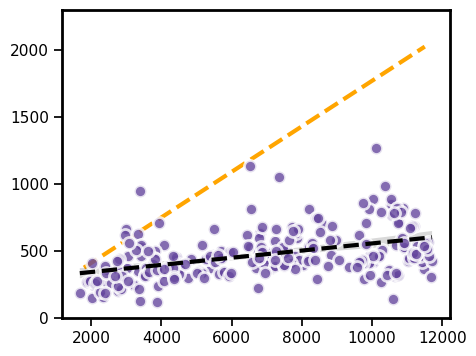

In [13]:
plt.figure(figsize=(5,4))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})
plt.plot([1800,11500],[375,2025], color='orange', linestyle='--', linewidth=3, zorder=1)
sns.regplot(data=big_df.dropna(axis=0), y='cell_num', x='measured_density', scatter_kws={'alpha':0}, line_kws={'color':'black', 'linestyle':'--'})
sns.scatterplot(data=big_df.dropna(axis=0), y='cell_num', x='measured_density', color=[cpal[6]], s=75, linewidth=2, alpha=0.8, legend=False)
plt.ylabel('')
plt.xlabel('')
plt.ylim(0,2300)
plt.savefig("fig4_density-v-cells-per-target.png", dpi=300, bbox_inches="tight")
#ax.set_xticklabels(['6','12','20'])
#plt.ylim(0,0.4)